In [1]:
import math, random, warnings
from time import time
from datetime import datetime
from collections import defaultdict
from IPython.core.interactiveshell import InteractiveShell

# Mathematical calculation
import numpy as np
from scipy.sparse.linalg import svds
from sklearn import model_selection
from sklearn.metrics.pairwise import cosine_similarity

# Data handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-surprise recommender package
!pip install surprise
from surprise import SVD, KNNWithMeans
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms.baseline_only import BaselineOnly

In [0]:
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
%matplotlib inline
# sns.set(style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the dataset into a Pandas dataframe called ratings and skip any lines that return an error
ratings = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ratings_Electronics.csv", 
                      names=['userId', 'productId', 'rating', 'timestamp'], 
                      na_values=['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null', '?'],
                      error_bad_lines=False,
                      warn_bad_lines=False)

# Save an original copy of the dataframe
original_ratings = ratings.copy(deep=True)

In [5]:
# Check the head of the dataset
ratings.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.000,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.000,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.000,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.000,1334707200


In [6]:
# Check the tail of the dataset
ratings.tail()

,userId,productId,rating,timestamp
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.000,1396569600
7824478,A322MDK0M89RHN,BT008UKTMW,5.000,1313366400
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.000,1404172800
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.000,1297555200
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.000,1312675200


In [7]:
# Get the shape and size of the dataset
print("Number of rows    :",ratings.shape[0])
print("Number of columns :",ratings.shape[1])

Number of rows    : 7824482
Number of columns : 4


In [8]:
# Get more info on it
# 1. Name of the columns
# 2. Find the data types of each columns
# 3. Look for any null/missing values
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [9]:
# Check for any missing values in the dataset
ratings.isna().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

Inferences:

The dataset consists of 7824482 rows and 4 columns. There are no missing or null values in the data.


In [10]:
# Check for duplicate values in userId and productId columns
rating_combination = ['userId', 'productId']
ratings[ratings.duplicated(subset=rating_combination)].sort_values(rating_combination).head()

# In case of duplicate values, drop those duplicates but no duplicates found in this case.
# ratings.drop_duplicates(subset=['userId','productId','rating'],inplace=True)

,userId,productId,rating,timestamp


In [11]:
# Convert the timestamp column to a readable date time format
ratings['timestamp'] = ratings.timestamp.apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

# Convert the datatype to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.000,2013-04-13
1,A2CX7LUOHB2NDG,0321732944,5.000,2012-07-01
2,A2NWSAGRHCP8N5,0439886341,1.000,2013-04-29
3,A2WNBOD3WNDNKT,0439886341,3.000,2013-07-22
4,A1GI0U4ZRJA8WN,0439886341,1.000,2012-04-18


In [12]:
# Get the timespan of data, minimum and maximum
print("Minimum recorded time:",ratings.timestamp.min())
print("Maximum recorded time:",ratings.timestamp.max())

Minimum recorded time: 1998-12-04 00:00:00
Maximum recorded time: 2014-07-23 00:00:00


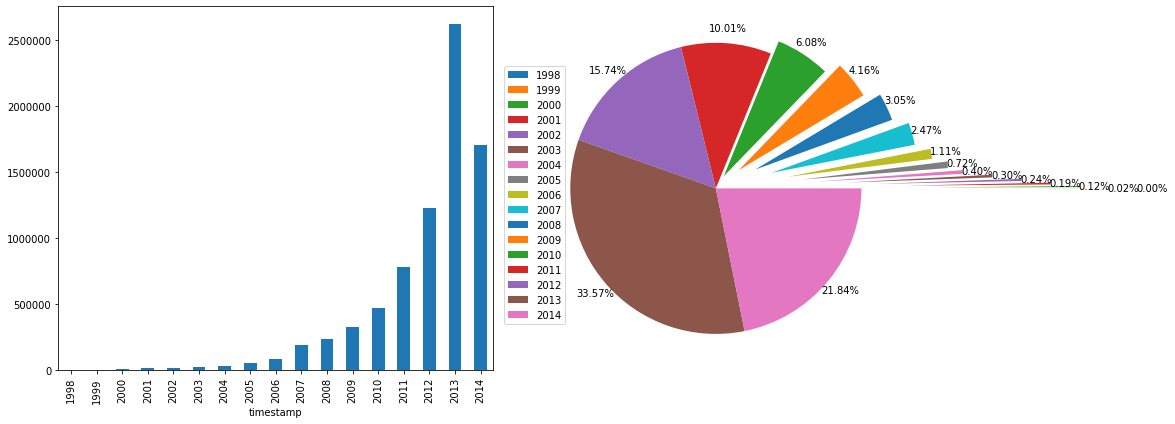

In [13]:
# Visualize the year wise ratings distribution
fig, ax = plt.subplots(1, 2, figsize=(16,6))
year_wise_count = ratings.timestamp.groupby(ratings['timestamp'].dt.year).count()
_  = year_wise_count.plot(kind='bar', ax=ax[0])
explode = (1.9,1.7,1.5,1.3,1.1,0.9,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,0,0,0)
_ = ax[1].pie(year_wise_count, explode=explode, autopct='%1.2f%%', pctdistance=1.1)
_ = ax[1].legend(labels=year_wise_count.index,bbox_to_anchor=(0.1,0.85))
plt.tight_layout()

The data is collected from year 1998 to 2014. The ratings of the product has been continously increasing except for an unusual hike in year 2013. After converting the timestamp to the readable format, we can see that it only contains date details with no details around time (HHMMSS). So we can't use this field, to make some kind of transaction out of it. Provided the hour, minute and seconds of purchase of a particular product, grouping of timestamps with products and user details, we could have suggested the products to be purchased in single transaction.
Besides this is a product review dataset, we can't apply Market Basket Analysis. So, we will be dropping the timestamp column.

In [14]:
# Drop Timestamp column
ratings.drop(labels='timestamp', axis=1, inplace=True)
ratings.head(2)

,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.000
1,A2CX7LUOHB2NDG,0321732944,5.000


In [15]:
# Check the count of unique user and product data and store it in a tuple
unique_original = (ratings.userId.nunique(),ratings.productId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 4201696
Count of unique Products : 476002


In [16]:
# Find the minimum and maximum ratings
print("The minimum rating is: ", ratings.rating.min())
print("The maximum rating is: ", ratings.rating.max())

The minimum rating is:  1.0
The maximum rating is:  5.0


In [17]:
# Check the distribution of ratings
print("Count of observations in each rating:")
ratings.rating.value_counts()

Count of observations in each rating:


5.000    4347541
4.000    1485781
1.000     901765
3.000     633073
2.000     456322
Name: rating, dtype: int64

Text(901765.02, 0.0, '11.5%')

Text(456322.02, 1.0, '5.8%')

Text(633073.02, 2.0, '8.1%')

Text(1485781.02, 3.0, '19.0%')

Text(4347541.02, 4.0, '55.6%')

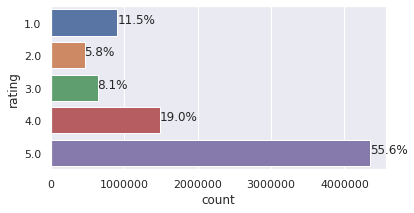

In [18]:
#Visualizing Ratings value count
ax = sns.set(rc={'figure.figsize':(6,3)})
ax = sns.countplot(y='rating', data=ratings)
total = len(ratings['rating'])

# Adding percentage to the horizontal bars
for p in ax.patches:
    percentage = '{:.1f}%'.format(100*p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))
plt.show()

# 56% of the the users have rated 5.0. Maximum no.of users have rated 5 for the products.

In [19]:
# Find the unique products under each ratings
ratings.groupby('rating')['productId'].nunique()

rating
1.000    176283
2.000    123419
3.000    152827
4.000    223845
5.000    358458
Name: productId, dtype: int64

High count observed in rating 5, indicates amazon delivers good products in the electronics category. With the above countplot, we can see high frequency is indicated in rating 5, followed by rating 4 and 1. We can see that indivuals are sensitive towards the extreme experiences. Basically, the ratings are observed when the customer is highly satisfied or extremely dissatisfied. Users do not bother to rate when they have average experience. This is the reason rating 2 and 3 are having low frequencies compared to others.

In [20]:
# Top 10 users based on ratings
most_rated = ratings.userId.value_counts().rename_axis('UserId').reset_index(name='ratings_count')
most_rated.head(10)

,UserId,ratings_count
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
5,A1ODOGXEYECQQ8,380
6,A36K2N527TXXJN,314
7,A2AY4YUOX2N1BQ,311
8,AWPODHOB4GFWL,308
9,ARBKYIVNYWK3C,296


In [21]:
# Find the density of the rating matrix
print("Total observed ratings in the dataset:", len(ratings))
possible_ratings = ratings.userId.nunique() * ratings.productId.nunique()
print("Total ratings possible for the dataset:", possible_ratings)
density = (len(ratings)/possible_ratings) * 100
print("Density of the dataset:",density)

# The dataset has a very low density

Total observed ratings in the dataset: 7824482
Total ratings possible for the dataset: 2000015699392
Density of the dataset: 0.0003912210290338533


In [22]:
# Drop the users who have rated less than 50 products
ratings = ratings[ratings.userId.isin(most_rated[most_rated['ratings_count'] >= 50].UserId)]
print('Unique USERS who have rated 50 or more products :', ratings.userId.nunique())
print('Unique USERS dropped:', unique_original[0] - ratings.userId.nunique())
print("Unique products remaining:", ratings.productId.nunique())
print('Unique Products dropped:', unique_original[1]-ratings.productId.nunique())
print('\nFinal length of the dataset:',len(ratings))

Unique USERS who have rated 50 or more products : 1540
Unique USERS dropped: 4200156
Unique products remaining: 48190
Unique Products dropped: 427812

Final length of the dataset: 125871


There are larger no of users (4200156) who haven't rated atleast 50 products. These records would not have drawn a proper analysis considering the total no. of records. Hence, we have dropped all these users and are left with 1540 unique users with 50 or more ratings under each one's umbrella. while dropping such users, we ended up dropping 427812 unique products and their ratings. Now we are left with only 48190 products and their ratings which is only 10% of the original list of products. Overall, we dropped 7824482-125871=7698611 records which is almost 98.4% of the original dataset.

In [23]:
# Find the density of the final matrix
# We are using pivot to reshape the dataframe
final_ratings_matrix = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
final_ratings_matrix.head(2)
print('Shape of final_ratings_matrix          :', final_ratings_matrix.shape)
print('Total observed ratings in the dataset  :', len(ratings))
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(ratings) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.2f}%'.format(density))

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,1400699169,1685560148,3744295508,7562434166,787988002X,8862935307,8862936826,9043413585,9573212900,9573212919,9575871979,9800359788,9981719005,9981734241,9981739588,9983722615,998376234X,9983891212,9984922626,9984984362,9985511298,9985511476,9985525264,9985696999,9989360391,B000000O48,B000001OKH,B000001OL6,...,B00KSTODWY,B00KT17TZ4,B00KTIYN7O,B00KU4RD4M,B00KV6FFN0,B00KVLY8E2,B00KVNY2KA,B00KW2W6B2,B00KW3OFG0,B00KWHMR6G,B00KWL62QI,B00KWMNDDM,B00KWPRSJY,B00KWWY1PQ,B00KXAFYZS,B00KXMN08E,B00KXUHX9S,B00KYA7CT8,B00KYMCJF8,B00L0YFJHY,B00L1I727Y,B00L1I80K2,B00L1NZTSS,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A100WO06OQR8BQ,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Shape of final_ratings_matrix          : (1540, 48190)
Total observed ratings in the dataset  : 125871
Total ratings possible for the dataset : 74212600
Density of the dataset                 : 0.17%


The intensity of the user-item matrix has increased. We will now calculate the increase in the density.

In [24]:
# Calculate the increase in density
print('The density of the user-item matrix increased by {:4.2f}%'.format((0.17-0.00039)/0.00039))

The density of the user-item matrix increased by 434.90%


After dropping about 98.4% of the data with very less ratings per user, the density of the resultant matrix increased by 434.9%. A density of 0.17% shows that the data set is still highly sparse such that it is not feasible to visualize with matplotlib spy.

In [25]:
# Divide the dataset in 70:30 ratio
trainset, testset = model_selection.train_test_split(ratings, test_size=0.3, random_state=42)
trainset.head(3)
testset.head(3)

,userId,productId,rating
3406191,A30R8VFR16RE32,B003KPBRRW,5.000
2044529,A3MMR2WDKAK0PA,B001GNBD8I,2.000
5706800,AGOH8N902URMW,B007BXD66E,5.000


,userId,productId,rating
10902,A2NB2E5DXE319Z,B00000J1UB,5.000
2733358,A1TY97ZGQT5FGF,B002NJP6B4,1.000
2931889,A2L42QEWR77PKZ,B002XITVCK,5.000


In [26]:
# Check the shape of training and test set
print('Shape of the training set  :', trainset.shape)
print('Shape of the test set      :', testset.shape)

Shape of the training set  : (88109, 3)
Shape of the test set      : (37762, 3)


Text(0.5, 1.0, 'Training Set')

Text(0.5, 1.0, 'Test Set')

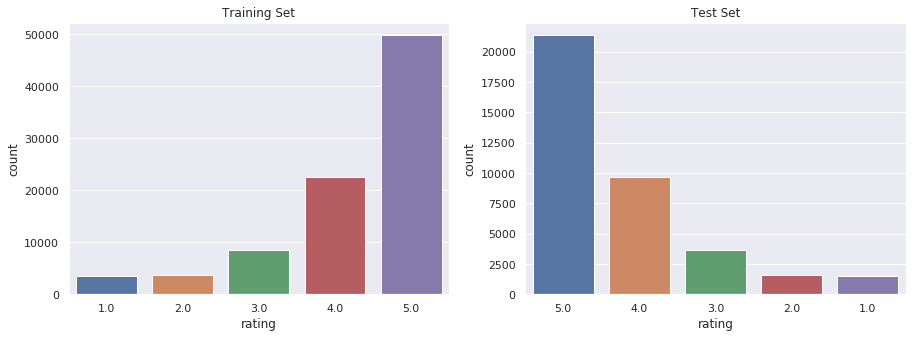

In [27]:
# Check the ratings distribution in both train and test set
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Training Set')
sns.countplot('rating', data=trainset, ax=axes[0])
axes[1].set_title('Test Set')
sns.countplot('rating', data=testset, ax=axes[1], order=testset.rating.value_counts().index)

Train Test set split resulted into 88109 training data and 37762 testing dataset. Both the datasets are having almost equal no of data points under each rating.

In [0]:
# Create a model to recommend models based on popularity
def recommend_popular(df, top_n, userId=None):
  # Generate recommendation based on score
  df['Rank'] = df['score'].rank(ascending=0, method='first')
  recommendations = df.sort_values(['score','productId'], ascending=[0,1])

  # Add UserId column for which the recommendations are being generated 
  if userId:
    recommendations.insert(0,'userId', userId)

  # Get the top n recommendations
  return recommendations.head(top_n)

In [29]:
# Count of userId for each unique product as recommendation score
product_grp = ratings.groupby(['productId']).agg({'userId':'count'}).reset_index()
product_grp.rename(columns={'userId': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [30]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
39003,B0088CJT4U,206,1.000
24827,B003ES5ZUU,184,2.000
11078,B000N99BBC,167,3.000
38250,B007WTAJTO,164,4.000
38615,B00829TIEK,149,5.000


In [31]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'mean'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.000
1,0594481813,3.000
2,0970407998,2.500
3,0972683275,4.750
4,1400501466,3.333


In [32]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
0,0594451647,5.000,1.000
5,1400501520,5.000,2.000
12,1400699169,5.000,3.000
13,1685560148,5.000,4.000
14,3744295508,5.000,5.000


In [33]:
#Count of user_id for each unique product as recommendation score 
product_grp = ratings.groupby(['productId']).agg({'rating': 'sum'}).reset_index()
product_grp.rename(columns={'rating': 'score'}, inplace=True)
product_grp.head()

,productId,score
0,0594451647,5.000
1,0594481813,3.000
2,0970407998,5.000
3,0972683275,19.000
4,1400501466,20.000


In [34]:
# Find recommendation for top 5 products
recommend_popular(product_grp, 5)

,productId,score,Rank
24827,B003ES5ZUU,895.000,1.000
39003,B0088CJT4U,869.000,2.000
11078,B000N99BBC,797.000,3.000
38250,B007WTAJTO,771.000,4.000
38615,B00829TIEK,661.000,5.000


In [35]:
# Find recommendation for couple of users
find_recom = {'A197T2N6RU7K56': 6, 
              'A1FR68QH6Z4YZM': 3, 
              'A10AFVU66A79Y1': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_popular(product_grp,find_recom[user],user)
    print("\n")

Top 6 recommendations for the userId: A197T2N6RU7K56


,userId,productId,score,Rank
24827,A197T2N6RU7K56,B003ES5ZUU,895.000,1.000
39003,A197T2N6RU7K56,B0088CJT4U,869.000,2.000
11078,A197T2N6RU7K56,B000N99BBC,797.000,3.000
38250,A197T2N6RU7K56,B007WTAJTO,771.000,4.000
38615,A197T2N6RU7K56,B00829TIEK,661.000,5.000
38611,A197T2N6RU7K56,B00829THK0,605.000,6.000




Top 3 recommendations for the userId: A1FR68QH6Z4YZM


,userId,productId,score,Rank
24827,A1FR68QH6Z4YZM,B003ES5ZUU,895.000,1.000
39003,A1FR68QH6Z4YZM,B0088CJT4U,869.000,2.000
11078,A1FR68QH6Z4YZM,B000N99BBC,797.000,3.000




Top 8 recommendations for the userId: A10AFVU66A79Y1


,userId,productId,score,Rank
24827,A10AFVU66A79Y1,B003ES5ZUU,895.000,1.000
39003,A10AFVU66A79Y1,B0088CJT4U,869.000,2.000
11078,A10AFVU66A79Y1,B000N99BBC,797.000,3.000
38250,A10AFVU66A79Y1,B007WTAJTO,771.000,4.000
38615,A10AFVU66A79Y1,B00829TIEK,661.000,5.000
38611,A10AFVU66A79Y1,B00829THK0,605.000,6.000
39338,A10AFVU66A79Y1,B008DWCRQW,561.000,7.000
28761,A10AFVU66A79Y1,B004CLYEDC,551.000,8.000


Popularity recommender models works based on the popularity of products. The products with highest number of ratings gets recommended irrespective of user's interest. This is the model used as a basic recommendation even when the user is not even logged into Amazon. So is observed above that all the 3 users recieved the same recommendations i.e the top n rated products under Electronics category. There is no personalization in this recommendation system.

Build Collaborative Filtering Model

Facing memory issue while working on collaborative filtering model, so taking only the top 10 most rated users processed data

In [36]:
# Top 10 users based on ratings
most_rated = ratings.userId.value_counts().rename_axis('UserId').reset_index(name='ratings_count')[:10]
most_rated.head(10)

,UserId,ratings_count
0,A5JLAU2ARJ0BO,520
1,ADLVFFE4VBT8,501
2,A3OXHLG6DIBRW8,498
3,A6FIAB28IS79,431
4,A680RUE1FDO8B,406
5,A1ODOGXEYECQQ8,380
6,A36K2N527TXXJN,314
7,A2AY4YUOX2N1BQ,311
8,AWPODHOB4GFWL,308
9,A25C2M3QF9G7OQ,296


In [37]:
ratings = ratings[ratings.userId.isin(most_rated[most_rated['ratings_count'] >= 50].UserId)]
print('Unique USERS who have rated 50 or more products :', ratings.userId.nunique())
print('Unique USERS dropped:', unique_original[0] - ratings.userId.nunique())
print("Unique products remaining:", ratings.productId.nunique())
print('Unique Products dropped:', unique_original[1]-ratings.productId.nunique())
print('\nFinal length of the dataset:',len(ratings))

Unique USERS who have rated 50 or more products : 10
Unique USERS dropped: 4201686
Unique products remaining: 3462
Unique Products dropped: 472540

Final length of the dataset: 3965


In [38]:
# Create the User-Item sparse matrix
user_item = ratings.pivot(index='userId', columns='productId', values='rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (10, 3462)


productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,B00002NDRF,B00003006E,B00003006R,B000031WDA,B00003CWDH,B00003G1RG,B00004S9AK,B00004SABB,B00004SB92,B00004T1KZ,B00004T1WU,B00004T1X6,B00004TDN0,B00004TJ0X,B00004TJ7O,B00004TKHY,B00004TS16,B00004TVSO,B00004TWM6,B00004TZGZ,B00004TZJJ,B00004TZJK,B00004TZJQ,B00004TZKO,...,B00JKH25DO,B00JO64MY6,B00JO80LUI,B00JP12170,B00JP474PQ,B00JP7R7DC,B00JPELAB0,B00JPG03GQ,B00JQTNVL6,B00JT4GIMC,B00JWV1LP6,B00JWXNT2M,B00JWXTOIA,B00JX1ZS5O,B00JXFM75Y,B00JXVPHC8,B00JZAB8OI,B00JZC972Q,B00JZM7T2Q,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KFBX9XY,B00KGCALLU,B00KGQC4QQ,B00KIMX4EY,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,4.000,0.000,0.000,0.000,0.000,4.000,4.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,5.000,5.000,0.000,5.000,3.000,0.000,0.000
A25C2M3QF9G7OQ,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.000,4.000,0.000,0.000,5.000,0.000,5.000,0.000,0.000,0.000,5.000,5.000,0.000,5.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000
A2AY4YUOX2N1BQ,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A36K2N527TXXJN,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,4.000,5.000,0.000,0.000,0.000,0.000,4.000,4.000,5.000,4.000,0.000,4.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A3OXHLG6DIBRW8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,5.000,0.000,0.000,0.000,0.000,2.000,0.000,5.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [39]:
# Create the Item-User sparse matrix
item_user = ratings.pivot(index='productId', columns='userId', values='rating').fillna(0)
print('Shape of Item-User sparse matrix:', item_user.shape)
item_user.head()

Shape of Item-User sparse matrix: (3462, 10)


userId,A1ODOGXEYECQQ8,A25C2M3QF9G7OQ,A2AY4YUOX2N1BQ,A36K2N527TXXJN,A3OXHLG6DIBRW8,A5JLAU2ARJ0BO,A680RUE1FDO8B,A6FIAB28IS79,ADLVFFE4VBT8,AWPODHOB4GFWL
productId,,,,,,,,,,
1400532655,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
9800359788,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000
9981719005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000
B000001OMI,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000
B00000J05A,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000


In [40]:
# Calculate the user-user similarity
user_similarity = cosine_similarity(user_item)
np.fill_diagonal(user_similarity, 0)
user_similarity_df = pd.DataFrame(user_similarity,index=user_item.index, columns=user_item.index)
user_similarity_df.head()

userId,A1ODOGXEYECQQ8,A25C2M3QF9G7OQ,A2AY4YUOX2N1BQ,A36K2N527TXXJN,A3OXHLG6DIBRW8,A5JLAU2ARJ0BO,A680RUE1FDO8B,A6FIAB28IS79,ADLVFFE4VBT8,AWPODHOB4GFWL
userId,,,,,,,,,,
A1ODOGXEYECQQ8,0.000,0.070,0.045,0.084,0.053,0.017,0.033,0.037,0.053,0.130
A25C2M3QF9G7OQ,0.070,0.000,0.038,0.128,0.055,0.008,0.031,0.008,0.074,0.104
A2AY4YUOX2N1BQ,0.045,0.038,0.000,0.023,0.023,0.000,0.003,0.018,0.030,0.034
A36K2N527TXXJN,0.084,0.128,0.023,0.000,0.061,0.008,0.030,0.024,0.088,0.086
A3OXHLG6DIBRW8,0.053,0.055,0.023,0.061,0.000,0.009,0.038,0.029,0.074,0.021


In [41]:
# Calculate the item-item similarity
item_similarity = cosine_similarity(item_user)
np.fill_diagonal(item_similarity, 0)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user.index, columns=item_user.index)
item_similarity_df.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,B00002NDRF,B00003006E,B00003006R,B000031WDA,B00003CWDH,B00003G1RG,B00004S9AK,B00004SABB,B00004SB92,B00004T1KZ,B00004T1WU,B00004T1X6,B00004TDN0,B00004TJ0X,B00004TJ7O,B00004TKHY,B00004TS16,B00004TVSO,B00004TWM6,B00004TZGZ,B00004TZJJ,B00004TZJK,B00004TZJQ,B00004TZKO,...,B00JKH25DO,B00JO64MY6,B00JO80LUI,B00JP12170,B00JP474PQ,B00JP7R7DC,B00JPELAB0,B00JPG03GQ,B00JQTNVL6,B00JT4GIMC,B00JWV1LP6,B00JWXNT2M,B00JWXTOIA,B00JX1ZS5O,B00JXFM75Y,B00JXVPHC8,B00JZAB8OI,B00JZC972Q,B00JZM7T2Q,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KFBX9XY,B00KGCALLU,B00KGQC4QQ,B00KIMX4EY,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1400532655,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9800359788,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.707,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.625,1.000,1.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9981719005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.707,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.707,0.000
B000001OMI,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
B00000J05A,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [0]:
# Method to find top N neighbors
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(axis=1, func=lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                                   index=['top{}'.format(i) for i in range(1, n+1)]))
    return df

In [43]:
# Find 10 neighbors of each user
user_10_neighbors = find_n_neighbors(user_similarity_df, 10)
user_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
userId,,,,,,,,,,
A1ODOGXEYECQQ8,AWPODHOB4GFWL,A36K2N527TXXJN,A25C2M3QF9G7OQ,A3OXHLG6DIBRW8,ADLVFFE4VBT8,A2AY4YUOX2N1BQ,A6FIAB28IS79,A680RUE1FDO8B,A5JLAU2ARJ0BO,A1ODOGXEYECQQ8
A25C2M3QF9G7OQ,A36K2N527TXXJN,AWPODHOB4GFWL,ADLVFFE4VBT8,A1ODOGXEYECQQ8,A3OXHLG6DIBRW8,A2AY4YUOX2N1BQ,A680RUE1FDO8B,A6FIAB28IS79,A5JLAU2ARJ0BO,A25C2M3QF9G7OQ
A2AY4YUOX2N1BQ,A1ODOGXEYECQQ8,A25C2M3QF9G7OQ,AWPODHOB4GFWL,ADLVFFE4VBT8,A36K2N527TXXJN,A3OXHLG6DIBRW8,A6FIAB28IS79,A680RUE1FDO8B,A5JLAU2ARJ0BO,A2AY4YUOX2N1BQ
A36K2N527TXXJN,A25C2M3QF9G7OQ,ADLVFFE4VBT8,AWPODHOB4GFWL,A1ODOGXEYECQQ8,A3OXHLG6DIBRW8,A680RUE1FDO8B,A6FIAB28IS79,A2AY4YUOX2N1BQ,A5JLAU2ARJ0BO,A36K2N527TXXJN
A3OXHLG6DIBRW8,ADLVFFE4VBT8,A36K2N527TXXJN,A25C2M3QF9G7OQ,A1ODOGXEYECQQ8,A680RUE1FDO8B,A6FIAB28IS79,A2AY4YUOX2N1BQ,AWPODHOB4GFWL,A5JLAU2ARJ0BO,A3OXHLG6DIBRW8
A5JLAU2ARJ0BO,AWPODHOB4GFWL,ADLVFFE4VBT8,A1ODOGXEYECQQ8,A680RUE1FDO8B,A6FIAB28IS79,A3OXHLG6DIBRW8,A36K2N527TXXJN,A25C2M3QF9G7OQ,A5JLAU2ARJ0BO,A2AY4YUOX2N1BQ
A680RUE1FDO8B,A3OXHLG6DIBRW8,AWPODHOB4GFWL,A1ODOGXEYECQQ8,A25C2M3QF9G7OQ,A36K2N527TXXJN,ADLVFFE4VBT8,A6FIAB28IS79,A5JLAU2ARJ0BO,A2AY4YUOX2N1BQ,A680RUE1FDO8B
A6FIAB28IS79,A1ODOGXEYECQQ8,AWPODHOB4GFWL,A3OXHLG6DIBRW8,ADLVFFE4VBT8,A36K2N527TXXJN,A680RUE1FDO8B,A2AY4YUOX2N1BQ,A5JLAU2ARJ0BO,A25C2M3QF9G7OQ,A6FIAB28IS79
ADLVFFE4VBT8,A36K2N527TXXJN,A25C2M3QF9G7OQ,A3OXHLG6DIBRW8,AWPODHOB4GFWL,A1ODOGXEYECQQ8,A2AY4YUOX2N1BQ,A6FIAB28IS79,A680RUE1FDO8B,A5JLAU2ARJ0BO,ADLVFFE4VBT8


In [0]:
def get_users_similar_products(user1, user2):
    common_products = ratings[ratings.userId == user1].merge(
    ratings[ratings.userId == user2],
    on = "productId",
    how = "inner" )
    return common_products[['rating_x', 'rating_y', 'productId']].head()

In [45]:
# Check the similarity of two users
get_users_similar_products('A1ODOGXEYECQQ8', 'AWPODHOB4GFWL')

,rating_x,rating_y,productId
0,4.000,5.000,B000F9YN22
1,4.000,5.000,B000JE7GPY
2,5.000,5.000,B000RHZJN4
3,4.000,5.000,B0015DYMVO
4,5.000,5.000,B001TH7GSW


From the above step we can see that the similarity we generated is true since both the given users ('A1ODOGXEYECQQ8', 'AWPODHOB4GFWL') have almost same ratings and likings.

In [0]:
# Method to predict the rating
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [47]:
# Predict the ratings for both UBCF and IBCF
st=time()
user_prediction = predict(user_item, user_similarity, type='user')
user_prediction = pd.DataFrame(user_prediction, index=user_item.index, columns=user_item.columns)
user_prediction.head()

item_prediction = predict(user_item, item_similarity, type='item')
#Commenting out following 2 lines as it throws MemoryError due to the high sparsity
#item_prediction = pd.DataFrame(item_prediction, index=item_user.index, columns=item_user.columns)
#item_prediction.head()
print('Time taken %.2fs to find out the user and item prediction' % (time()-st))

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,B00002NDRF,B00003006E,B00003006R,B000031WDA,B00003CWDH,B00003G1RG,B00004S9AK,B00004SABB,B00004SB92,B00004T1KZ,B00004T1WU,B00004T1X6,B00004TDN0,B00004TJ0X,B00004TJ7O,B00004TKHY,B00004TS16,B00004TVSO,B00004TWM6,B00004TZGZ,B00004TZJJ,B00004TZJK,B00004TZJQ,B00004TZKO,...,B00JKH25DO,B00JO64MY6,B00JO80LUI,B00JP12170,B00JP474PQ,B00JP7R7DC,B00JPELAB0,B00JPG03GQ,B00JQTNVL6,B00JT4GIMC,B00JWV1LP6,B00JWXNT2M,B00JWXTOIA,B00JX1ZS5O,B00JXFM75Y,B00JXVPHC8,B00JZAB8OI,B00JZC972Q,B00JZM7T2Q,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KFBX9XY,B00KGCALLU,B00KGQC4QQ,B00KIMX4EY,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.037,0.806,0.308,0.323,0.217,0.998,0.359,0.217,0.998,0.413,0.515,0.217,0.217,0.359,0.146,0.208,0.409,1.316,0.170,0.310,0.288,0.104,0.170,0.004,0.137,0.137,0.359,0.288,0.359,1.246,0.515,0.288,0.170,0.070,1.246,0.217,0.288,0.288,0.217,0.217,...,0.539,0.539,0.806,0.409,0.673,0.409,0.673,1.246,0.004,1.246,1.529,0.673,0.510,1.180,0.004,0.510,0.004,0.406,0.646,0.646,0.806,0.004,0.004,0.004,0.673,1.315,0.646,0.806,0.646,1.246,0.646,0.004,0.806,0.004,0.004,0.510,0.004,0.004,1.753,0.673
A25C2M3QF9G7OQ,-0.070,1.154,0.345,0.216,-0.035,0.724,-0.002,-0.035,0.724,0.342,0.449,-0.035,-0.035,-0.002,-0.052,0.129,0.489,1.687,-0.012,0.235,-0.019,-0.041,-0.012,0.460,-0.026,-0.026,-0.002,-0.019,-0.002,0.926,0.449,-0.019,-0.012,-0.055,0.926,-0.035,-0.019,-0.019,-0.035,-0.035,...,-0.085,-0.085,1.154,0.489,0.460,0.489,-0.085,0.926,0.596,0.926,0.740,-0.085,0.632,0.632,0.460,0.632,0.460,-0.085,0.906,0.906,1.154,0.460,0.460,0.460,-0.085,0.906,0.906,1.154,0.906,0.926,0.906,0.596,1.154,0.596,0.596,0.632,0.596,0.324,1.643,-0.085
A2AY4YUOX2N1BQ,-0.073,0.471,0.354,-0.010,0.178,0.567,0.346,0.178,0.567,0.351,0.457,0.178,0.178,0.346,0.095,0.139,0.496,1.000,-0.073,0.245,0.262,-0.073,-0.073,0.772,-0.073,-0.073,0.346,0.262,0.346,0.727,0.457,0.262,-0.073,-0.073,0.727,0.178,0.262,0.262,0.178,0.178,...,0.629,0.629,0.471,0.496,1.649,0.496,0.804,0.727,0.983,0.727,1.334,0.804,0.639,1.516,0.772,0.639,0.772,0.453,0.362,0.362,0.471,0.772,0.772,0.772,0.804,1.239,0.362,0.471,0.362,0.727,0.362,0.983,0.471,0.983,0.983,0.639,0.983,0.561,1.439,0.804
A36K2N527TXXJN,-0.063,-0.078,0.420,0.204,0.058,0.568,0.148,0.058,0.568,0.382,0.496,0.058,0.058,0.148,0.013,0.152,0.586,0.496,-0.006,0.267,0.103,-0.035,-0.006,0.555,-0.020,-0.020,0.148,0.103,0.148,0.729,0.496,0.103,-0.006,-0.049,0.729,0.058,0.103,0.103,0.058,0.058,...,0.883,0.883,-0.078,0.586,1.756,0.586,1.123,0.729,0.713,0.729,1.873,1.123,0.752,1.953,0.555,0.752,0.555,0.643,-0.078,-0.078,-0.078,0.555,0.555,0.555,1.123,1.123,-0.078,-0.078,-0.078,0.729,-0.078,0.713,-0.078,0.713,0.713,0.752,0.713,0.397,1.559,1.123
A3OXHLG6DIBRW8,0.182,0.998,0.768,0.683,0.400,0.385,0.562,0.400,0.385,0.157,0.157,0.400,0.400,0.562,0.319,0.157,0.972,0.998,0.278,0.157,0.481,0.230,0.278,0.747,0.254,0.254,0.562,0.481,0.562,0.441,0.157,0.481,0.278,0.206,0.441,0.400,0.481,0.481,0.400,0.400,...,0.764,0.764,0.998,0.972,1.505,0.972,0.915,0.441,0.895,0.441,1.165,0.915,1.175,1.933,0.747,1.175,0.747,0.612,0.830,0.830,0.998,0.747,0.747,0.747,0.915,1.587,0.830,0.998,0.830,0.441,0.830,0.895,0.998,0.895,0.895,1.175,0.895,0.600,1.459,0.915


Time taken 1.24s to find out the user and item prediction


In [0]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, orig_df, preds_df, top_n):
    # Get and sort the user's ratings
    sorted_user_ratings = orig_df.loc[userId].sort_values(ascending=False) #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False) #sorted_user_predictions

    # Prepare recommendations
    recommedations = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    recommedations.index.name = 'Recommended Items'
    recommedations.columns = ['user_ratings', 'user_predictions']
    
    # Take the products which user has NOT rated
    recommedations = recommedations.loc[recommedations.user_ratings == 0] 
    recommedations = recommedations.sort_values('user_predictions', ascending=False)
    return recommedations.head(top_n)

In [49]:
# Find recommendation for couple of users using UBCF
find_recom = {'A1ODOGXEYECQQ8': 6, 
              'A25C2M3QF9G7OQ': 3, 
              'A2AY4YUOX2N1BQ': 8}   # This list is user, top_n recommendation dict.
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, user_prediction, find_recom[user])
    print("\n")

Top 6 recommendations for the userId: A1ODOGXEYECQQ8


,user_ratings,user_predictions
Recommended Items,,
B000JMJWV2,0.000,3.216
B00DK2JQOQ,0.000,2.986
B00GMTN96U,0.000,2.717
B00GTLN1BO,0.000,2.717
B00HZVPD72,0.000,2.717
B00HFFDDLG,0.000,2.557




Top 3 recommendations for the userId: A25C2M3QF9G7OQ


,user_ratings,user_predictions
Recommended Items,,
B00DK2JQOQ,0.000,3.245
B00CAXC986,0.000,2.881
B001TH7GSW,0.000,2.845




Top 8 recommendations for the userId: A2AY4YUOX2N1BQ


,user_ratings,user_predictions
Recommended Items,,
B00D5EO27U,0.000,3.562
B007OY5V68,0.000,3.456
B00CZDT30S,0.000,3.449
B0079UAT0A,0.000,3.434
B0053R0WWG,0.000,3.360
B00E3FHXYO,0.000,3.204
B00EDCF0MY,0.000,3.204
B000JMJWV2,0.000,3.181


Unlike popularity model, the recommendations are personalized here as indicated by the different set of recommendations for different users based on their likings. It is taking too long to calculate the item-item similarity as the item base is pretty huge than the user base.

In [0]:

# Singular Value Decomposition
U, sigma, Vt = svds(user_item, k = 9)

In [51]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 1.61681762e-01  5.99673907e-01 -3.20297676e-01  4.43969070e-01
   3.08144306e-01  2.40738305e-01  4.82955225e-02 -1.04187927e-01
   2.51041663e-01]
 [-4.67751801e-01 -3.83928313e-01  3.76331853e-01  3.10896896e-01
   9.73933992e-02  1.26131500e-01 -2.03614702e-02 -9.57506248e-02
   2.23465170e-01]
 [ 8.67786878e-02 -6.37335764e-01 -7.30083988e-01  1.39342350e-01
   1.34328890e-01  5.25920254e-02 -1.84514864e-02 -4.27560482e-02
   9.85310415e-02]
 [ 7.03800833e-01 -2.71380265e-01  4.53994481e-01  2.72554458e-01
   1.21826936e-01  1.21106899e-01 -2.76936168e-02 -1.05249770e-01
   2.45674379e-01]
 [-3.41935631e-02  2.57757226e-02 -1.80096047e-02 -4.33015027e-02
  -5.20348907e-02 -2.10893897e-01  4.54060395e-02  7.43896202e-01
   6.25934665e-01]
 [ 1.40117231e-02 -2.72381911e-02  6.00275389e-04  1.86108515e-02
  -5.38188314e-02 -3.17814272e-01  9.10039123e-01 -2.35042043e-01
   1.05837228e-01]
 [ 1.49983298e-02 -1.29893356e-02 -4.90116752e-02 -2.19678566e-01
  -5

In [52]:
print('Sigma: \n',sigma)

Sigma: 
 [ 75.76480125  80.43142593  80.74626585  87.79707725  89.39608395
  91.79151519  94.1732432   96.25839177 107.5370882 ]


As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [53]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 75.76480125   0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.          80.43142593   0.           0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.          80.74626585   0.           0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.          87.79707725   0.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          89.39608395
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   91.79151519   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.          94.1732432    0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.          96.25839177   0.        ]
 [  0.           0.           0.           0.           0.
  

In [54]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 1.84937107e-04  4.64464251e-02 -2.34878384e-04 ...  6.40198717e-03
  -3.34203676e-02 -3.08686747e-02]
 [-3.38651102e-04 -1.68702881e-02  3.15151774e-03 ...  2.23671494e-02
   8.80476075e-03 -2.38668100e-02]
 [ 7.43409473e-06  2.81124134e-02 -2.87411300e-03 ... -1.19001544e-02
  -1.32067973e-03  2.33033596e-02]
 ...
 [ 9.66345739e-03 -1.47035484e-03 -1.03368664e-02 ...  1.53851097e-03
  -1.59814754e-02 -1.08106451e-03]
 [-2.44178236e-03 -5.46704385e-03 -1.80046038e-02 ... -3.24713279e-03
  -3.77540162e-02 -4.97362479e-03]
 [ 9.84192803e-04  1.14227744e-02  1.58319625e-02 ...  7.00339763e-03
   3.52688476e-02  1.03901442e-02]]


In [55]:
#Predicted ratings
pred_list = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(pred_list, columns = user_item.columns)
preds_df.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,B00002NDRF,B00003006E,B00003006R,B000031WDA,B00003CWDH,B00003G1RG,B00004S9AK,B00004SABB,B00004SB92,B00004T1KZ,B00004T1WU,B00004T1X6,B00004TDN0,B00004TJ0X,B00004TJ7O,B00004TKHY,B00004TS16,B00004TVSO,B00004TWM6,B00004TZGZ,B00004TZJJ,B00004TZJK,B00004TZJQ,B00004TZKO,...,B00JKH25DO,B00JO64MY6,B00JO80LUI,B00JP12170,B00JP474PQ,B00JP7R7DC,B00JPELAB0,B00JPG03GQ,B00JQTNVL6,B00JT4GIMC,B00JWV1LP6,B00JWXNT2M,B00JWXTOIA,B00JX1ZS5O,B00JXFM75Y,B00JXVPHC8,B00JZAB8OI,B00JZC972Q,B00JZM7T2Q,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KFBX9XY,B00KGCALLU,B00KGQC4QQ,B00KIMX4EY,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
0,-0.004,0.323,-0.025,-0.013,-0.038,0.867,-0.064,-0.038,0.867,0.046,0.057,-0.038,-0.038,-0.064,-0.026,0.023,-0.034,0.381,-0.020,0.034,-0.051,-0.012,-0.020,3.658,-0.016,-0.016,-0.064,-0.051,-0.064,1.083,0.057,-0.051,-0.020,-0.008,1.083,-0.038,-0.051,-0.051,-0.038,-0.038,...,-0.652,-0.652,0.323,-0.034,2.844,-0.034,-0.815,1.083,4.573,1.083,-0.717,-0.815,-0.042,-0.857,3.658,-0.042,3.658,-0.489,0.259,0.259,0.323,3.658,3.658,3.658,-0.815,-0.556,0.259,0.323,0.259,1.083,0.259,4.573,0.323,4.573,4.573,-0.042,4.573,2.744,1.041,-0.815
1,-0.008,0.616,-0.048,-0.024,-0.073,1.652,-0.122,-0.073,1.652,0.088,0.110,-0.073,-0.073,-0.122,-0.049,0.044,-0.065,0.726,-0.039,0.066,-0.098,-0.023,-0.039,-0.652,-0.031,-0.031,-0.122,-0.098,-0.122,2.065,0.110,-0.098,-0.039,-0.016,2.065,-0.073,-0.098,-0.098,-0.073,-0.073,...,2.758,2.758,0.616,-0.065,2.795,-0.065,3.447,2.065,-0.815,2.065,3.632,3.447,-0.081,3.366,-0.652,-0.081,-0.652,2.068,0.493,0.493,0.616,-0.652,-0.652,-0.652,3.447,3.940,0.493,0.616,0.493,2.065,0.493,-0.815,0.616,-0.815,-0.815,-0.081,-0.815,-0.489,1.985,3.447
2,0.000,-0.037,0.003,0.001,0.004,-0.100,0.007,0.004,-0.100,-0.005,-0.007,0.004,0.004,0.007,0.003,-0.003,0.004,-0.044,0.002,-0.004,0.006,0.001,0.002,0.040,0.002,0.002,0.007,0.006,0.007,-0.125,-0.007,0.006,0.002,0.001,-0.125,0.004,0.006,0.006,0.004,0.004,...,0.075,0.075,-0.037,0.004,0.134,0.004,0.094,-0.125,0.049,-0.125,4.083,0.094,0.005,0.099,0.040,0.005,0.040,0.057,-0.030,-0.030,-0.037,0.040,0.040,0.040,0.094,0.064,-0.030,-0.037,-0.030,-0.125,-0.030,0.049,-0.037,0.049,0.049,0.005,0.049,0.030,-0.121,0.094
3,0.003,4.755,0.019,0.010,0.029,-0.656,0.049,0.029,-0.656,-0.035,-0.043,0.029,0.029,0.049,0.019,-0.017,0.026,4.712,0.015,-0.026,0.039,0.009,0.015,0.259,0.012,0.012,0.049,0.039,0.049,-0.820,-0.043,0.039,0.015,0.006,-0.820,0.029,0.039,0.039,0.029,0.029,...,0.493,0.493,4.755,0.026,0.875,0.026,0.616,-0.820,0.323,-0.820,0.543,0.616,0.032,0.648,0.259,0.032,0.259,0.370,3.804,3.804,4.755,0.259,0.259,0.259,0.616,4.421,3.804,4.755,3.804,-0.820,3.804,0.323,4.755,0.323,0.323,0.032,0.323,0.194,-0.788,0.616
4,0.001,-0.043,0.003,0.002,0.005,-0.117,0.009,0.005,-0.117,3.994,4.992,0.005,0.005,0.009,0.003,1.997,0.005,4.949,0.003,2.995,0.007,0.002,0.003,0.046,0.002,0.002,0.009,0.007,0.009,-0.146,4.992,0.007,0.003,0.001,-0.146,0.005,0.007,0.007,0.005,0.005,...,0.088,0.088,-0.043,0.005,0.156,0.005,0.110,-0.146,0.057,-0.146,5.097,0.110,0.006,0.115,0.046,0.006,0.046,0.066,-0.035,-0.035,-0.043,0.046,0.046,0.046,0.110,0.075,-0.035,-0.043,-0.035,-0.146,-0.035,0.057,-0.043,0.057,0.057,0.006,0.057,0.034,-0.140,0.110


### Evaluation of Model

In [56]:
user_prediction.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,B00002NDRF,B00003006E,B00003006R,B000031WDA,B00003CWDH,B00003G1RG,B00004S9AK,B00004SABB,B00004SB92,B00004T1KZ,B00004T1WU,B00004T1X6,B00004TDN0,B00004TJ0X,B00004TJ7O,B00004TKHY,B00004TS16,B00004TVSO,B00004TWM6,B00004TZGZ,B00004TZJJ,B00004TZJK,B00004TZJQ,B00004TZKO,...,B00JKH25DO,B00JO64MY6,B00JO80LUI,B00JP12170,B00JP474PQ,B00JP7R7DC,B00JPELAB0,B00JPG03GQ,B00JQTNVL6,B00JT4GIMC,B00JWV1LP6,B00JWXNT2M,B00JWXTOIA,B00JX1ZS5O,B00JXFM75Y,B00JXVPHC8,B00JZAB8OI,B00JZC972Q,B00JZM7T2Q,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KFBX9XY,B00KGCALLU,B00KGQC4QQ,B00KIMX4EY,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1ODOGXEYECQQ8,0.037,0.806,0.308,0.323,0.217,0.998,0.359,0.217,0.998,0.413,0.515,0.217,0.217,0.359,0.146,0.208,0.409,1.316,0.170,0.310,0.288,0.104,0.170,0.004,0.137,0.137,0.359,0.288,0.359,1.246,0.515,0.288,0.170,0.070,1.246,0.217,0.288,0.288,0.217,0.217,...,0.539,0.539,0.806,0.409,0.673,0.409,0.673,1.246,0.004,1.246,1.529,0.673,0.510,1.180,0.004,0.510,0.004,0.406,0.646,0.646,0.806,0.004,0.004,0.004,0.673,1.315,0.646,0.806,0.646,1.246,0.646,0.004,0.806,0.004,0.004,0.510,0.004,0.004,1.753,0.673
A25C2M3QF9G7OQ,-0.070,1.154,0.345,0.216,-0.035,0.724,-0.002,-0.035,0.724,0.342,0.449,-0.035,-0.035,-0.002,-0.052,0.129,0.489,1.687,-0.012,0.235,-0.019,-0.041,-0.012,0.460,-0.026,-0.026,-0.002,-0.019,-0.002,0.926,0.449,-0.019,-0.012,-0.055,0.926,-0.035,-0.019,-0.019,-0.035,-0.035,...,-0.085,-0.085,1.154,0.489,0.460,0.489,-0.085,0.926,0.596,0.926,0.740,-0.085,0.632,0.632,0.460,0.632,0.460,-0.085,0.906,0.906,1.154,0.460,0.460,0.460,-0.085,0.906,0.906,1.154,0.906,0.926,0.906,0.596,1.154,0.596,0.596,0.632,0.596,0.324,1.643,-0.085
A2AY4YUOX2N1BQ,-0.073,0.471,0.354,-0.010,0.178,0.567,0.346,0.178,0.567,0.351,0.457,0.178,0.178,0.346,0.095,0.139,0.496,1.000,-0.073,0.245,0.262,-0.073,-0.073,0.772,-0.073,-0.073,0.346,0.262,0.346,0.727,0.457,0.262,-0.073,-0.073,0.727,0.178,0.262,0.262,0.178,0.178,...,0.629,0.629,0.471,0.496,1.649,0.496,0.804,0.727,0.983,0.727,1.334,0.804,0.639,1.516,0.772,0.639,0.772,0.453,0.362,0.362,0.471,0.772,0.772,0.772,0.804,1.239,0.362,0.471,0.362,0.727,0.362,0.983,0.471,0.983,0.983,0.639,0.983,0.561,1.439,0.804
A36K2N527TXXJN,-0.063,-0.078,0.420,0.204,0.058,0.568,0.148,0.058,0.568,0.382,0.496,0.058,0.058,0.148,0.013,0.152,0.586,0.496,-0.006,0.267,0.103,-0.035,-0.006,0.555,-0.020,-0.020,0.148,0.103,0.148,0.729,0.496,0.103,-0.006,-0.049,0.729,0.058,0.103,0.103,0.058,0.058,...,0.883,0.883,-0.078,0.586,1.756,0.586,1.123,0.729,0.713,0.729,1.873,1.123,0.752,1.953,0.555,0.752,0.555,0.643,-0.078,-0.078,-0.078,0.555,0.555,0.555,1.123,1.123,-0.078,-0.078,-0.078,0.729,-0.078,0.713,-0.078,0.713,0.713,0.752,0.713,0.397,1.559,1.123
A3OXHLG6DIBRW8,0.182,0.998,0.768,0.683,0.400,0.385,0.562,0.400,0.385,0.157,0.157,0.400,0.400,0.562,0.319,0.157,0.972,0.998,0.278,0.157,0.481,0.230,0.278,0.747,0.254,0.254,0.562,0.481,0.562,0.441,0.157,0.481,0.278,0.206,0.441,0.400,0.481,0.481,0.400,0.400,...,0.764,0.764,0.998,0.972,1.505,0.972,0.915,0.441,0.895,0.441,1.165,0.915,1.175,1.933,0.747,1.175,0.747,0.612,0.830,0.830,0.998,0.747,0.747,0.747,0.915,1.587,0.830,0.998,0.830,0.441,0.830,0.895,0.998,0.895,0.895,1.175,0.895,0.600,1.459,0.915


In [57]:
user_prediction.mean().head()

productId
1400532655   0.042
9800359788   0.689
9981719005   0.394
B000001OMI   0.333
B00000J05A   0.202
dtype: float64

In [58]:
# Predicted ratings 
preds_df.head()

productId,1400532655,9800359788,9981719005,B000001OMI,B00000J05A,B00000J1QS,B00000J1UQ,B00000J4CY,B00000JGNB,B00000JHX1,B00000JLSJ,B00001P4X5,B00001P4ZH,B00001W0DI,B000023VUL,B000026D8E,B00002NDRF,B00003006E,B00003006R,B000031WDA,B00003CWDH,B00003G1RG,B00004S9AK,B00004SABB,B00004SB92,B00004T1KZ,B00004T1WU,B00004T1X6,B00004TDN0,B00004TJ0X,B00004TJ7O,B00004TKHY,B00004TS16,B00004TVSO,B00004TWM6,B00004TZGZ,B00004TZJJ,B00004TZJK,B00004TZJQ,B00004TZKO,...,B00JKH25DO,B00JO64MY6,B00JO80LUI,B00JP12170,B00JP474PQ,B00JP7R7DC,B00JPELAB0,B00JPG03GQ,B00JQTNVL6,B00JT4GIMC,B00JWV1LP6,B00JWXNT2M,B00JWXTOIA,B00JX1ZS5O,B00JXFM75Y,B00JXVPHC8,B00JZAB8OI,B00JZC972Q,B00JZM7T2Q,B00K6ZAKCW,B00K91DB7Y,B00KB3T7AU,B00KB4DRVE,B00KCAPAKI,B00KCXRMKG,B00KFBX9XY,B00KGCALLU,B00KGQC4QQ,B00KIMX4EY,B00KINSDK8,B00KLGSQJ0,B00KNEBRT6,B00KVNY2KA,B00KWMNDDM,B00KYMCJF8,B00L1I80K2,B00L21HC7A,B00L26YDA4,B00L3YHF6O,B00LGQ6HL8
0,-0.004,0.323,-0.025,-0.013,-0.038,0.867,-0.064,-0.038,0.867,0.046,0.057,-0.038,-0.038,-0.064,-0.026,0.023,-0.034,0.381,-0.020,0.034,-0.051,-0.012,-0.020,3.658,-0.016,-0.016,-0.064,-0.051,-0.064,1.083,0.057,-0.051,-0.020,-0.008,1.083,-0.038,-0.051,-0.051,-0.038,-0.038,...,-0.652,-0.652,0.323,-0.034,2.844,-0.034,-0.815,1.083,4.573,1.083,-0.717,-0.815,-0.042,-0.857,3.658,-0.042,3.658,-0.489,0.259,0.259,0.323,3.658,3.658,3.658,-0.815,-0.556,0.259,0.323,0.259,1.083,0.259,4.573,0.323,4.573,4.573,-0.042,4.573,2.744,1.041,-0.815
1,-0.008,0.616,-0.048,-0.024,-0.073,1.652,-0.122,-0.073,1.652,0.088,0.110,-0.073,-0.073,-0.122,-0.049,0.044,-0.065,0.726,-0.039,0.066,-0.098,-0.023,-0.039,-0.652,-0.031,-0.031,-0.122,-0.098,-0.122,2.065,0.110,-0.098,-0.039,-0.016,2.065,-0.073,-0.098,-0.098,-0.073,-0.073,...,2.758,2.758,0.616,-0.065,2.795,-0.065,3.447,2.065,-0.815,2.065,3.632,3.447,-0.081,3.366,-0.652,-0.081,-0.652,2.068,0.493,0.493,0.616,-0.652,-0.652,-0.652,3.447,3.940,0.493,0.616,0.493,2.065,0.493,-0.815,0.616,-0.815,-0.815,-0.081,-0.815,-0.489,1.985,3.447
2,0.000,-0.037,0.003,0.001,0.004,-0.100,0.007,0.004,-0.100,-0.005,-0.007,0.004,0.004,0.007,0.003,-0.003,0.004,-0.044,0.002,-0.004,0.006,0.001,0.002,0.040,0.002,0.002,0.007,0.006,0.007,-0.125,-0.007,0.006,0.002,0.001,-0.125,0.004,0.006,0.006,0.004,0.004,...,0.075,0.075,-0.037,0.004,0.134,0.004,0.094,-0.125,0.049,-0.125,4.083,0.094,0.005,0.099,0.040,0.005,0.040,0.057,-0.030,-0.030,-0.037,0.040,0.040,0.040,0.094,0.064,-0.030,-0.037,-0.030,-0.125,-0.030,0.049,-0.037,0.049,0.049,0.005,0.049,0.030,-0.121,0.094
3,0.003,4.755,0.019,0.010,0.029,-0.656,0.049,0.029,-0.656,-0.035,-0.043,0.029,0.029,0.049,0.019,-0.017,0.026,4.712,0.015,-0.026,0.039,0.009,0.015,0.259,0.012,0.012,0.049,0.039,0.049,-0.820,-0.043,0.039,0.015,0.006,-0.820,0.029,0.039,0.039,0.029,0.029,...,0.493,0.493,4.755,0.026,0.875,0.026,0.616,-0.820,0.323,-0.820,0.543,0.616,0.032,0.648,0.259,0.032,0.259,0.370,3.804,3.804,4.755,0.259,0.259,0.259,0.616,4.421,3.804,4.755,3.804,-0.820,3.804,0.323,4.755,0.323,0.323,0.032,0.323,0.194,-0.788,0.616
4,0.001,-0.043,0.003,0.002,0.005,-0.117,0.009,0.005,-0.117,3.994,4.992,0.005,0.005,0.009,0.003,1.997,0.005,4.949,0.003,2.995,0.007,0.002,0.003,0.046,0.002,0.002,0.009,0.007,0.009,-0.146,4.992,0.007,0.003,0.001,-0.146,0.005,0.007,0.007,0.005,0.005,...,0.088,0.088,-0.043,0.005,0.156,0.005,0.110,-0.146,0.057,-0.146,5.097,0.110,0.006,0.115,0.046,0.006,0.046,0.066,-0.035,-0.035,-0.043,0.046,0.046,0.046,0.110,0.075,-0.035,-0.043,-0.035,-0.146,-0.035,0.057,-0.043,0.057,0.057,0.006,0.057,0.034,-0.140,0.110


In [59]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
1400532655   0.100
9800359788   0.490
9981719005   0.301
B000001OMI   0.500
B00000J05A   0.301
dtype: float64

In [60]:
rmse_df = pd.concat([user_prediction.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(3462, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
1400532655,0.042,0.100,0
9800359788,0.689,0.490,1
9981719005,0.394,0.301,2
B000001OMI,0.333,0.500,3
B00000J05A,0.202,0.301,4


In [61]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.20275 



In [62]:
# Trying out different latent factors
svd_list = [svds(user_item, k=k) for k in range(1,10)]
pred_list = [pd.DataFrame(np.dot(np.dot(svd[0], np.diag(svd[1])), svd[2]), 
                          index=user_item.index, 
                          columns=user_item.columns) for svd in svd_list]
RMSE_list = [round((((user_item.mean() - pred.mean()) ** 2).mean() ** 0.5), 5) for pred in pred_list]
RMSE_list

[0.26968,
 0.25034,
 0.19754,
 0.14111,
 0.09848,
 0.08916,
 0.08293,
 0.01234,
 0.0114]

In [63]:
print("The Average RMSE of SVD model is:",np.mean(RMSE_list))

The Average RMSE of SVD model is: 0.12810888888888888


### Getting top - K ( K = 5) recommendations.

In [64]:
user = 'A1ODOGXEYECQQ8'
num_recommendations = 5
print("Below are the recommendations for the user",user)
recommend_items(user, user_item, user_prediction, num_recommendations)

Below are the recommendations for the user A1ODOGXEYECQQ8


,user_ratings,user_predictions
Recommended Items,,
B000JMJWV2,0.000,3.216
B00DK2JQOQ,0.000,2.986
B00GMTN96U,0.000,2.717
B00GTLN1BO,0.000,2.717
B00HZVPD72,0.000,2.717


The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.The Popularity based model has recommended the same set of 5 products to different set of users but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.